# Fuzzy C-Means 分类任务

### IRIS 数据集

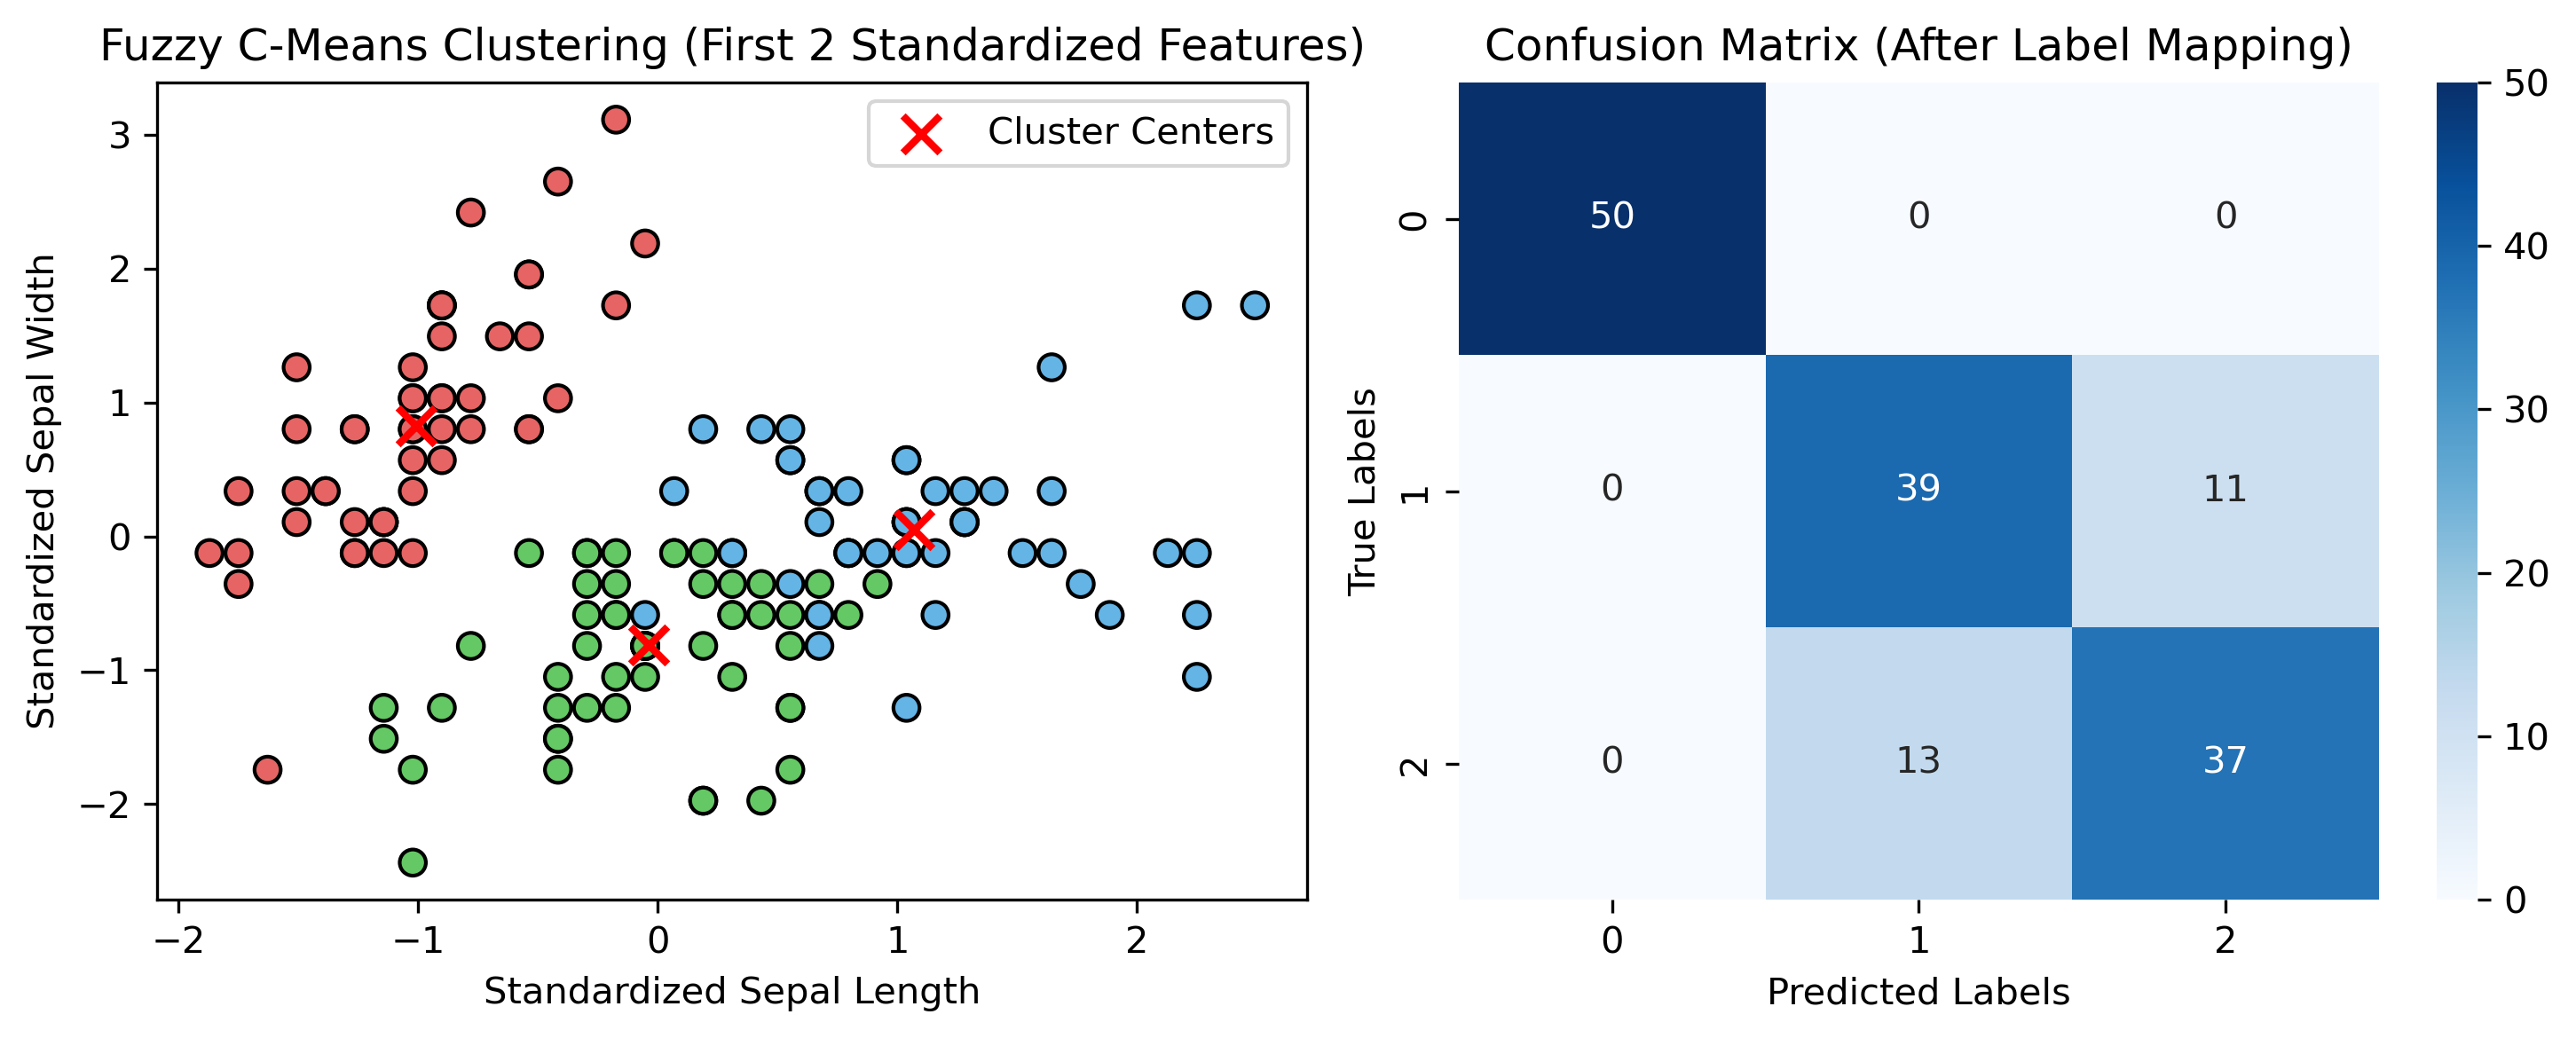

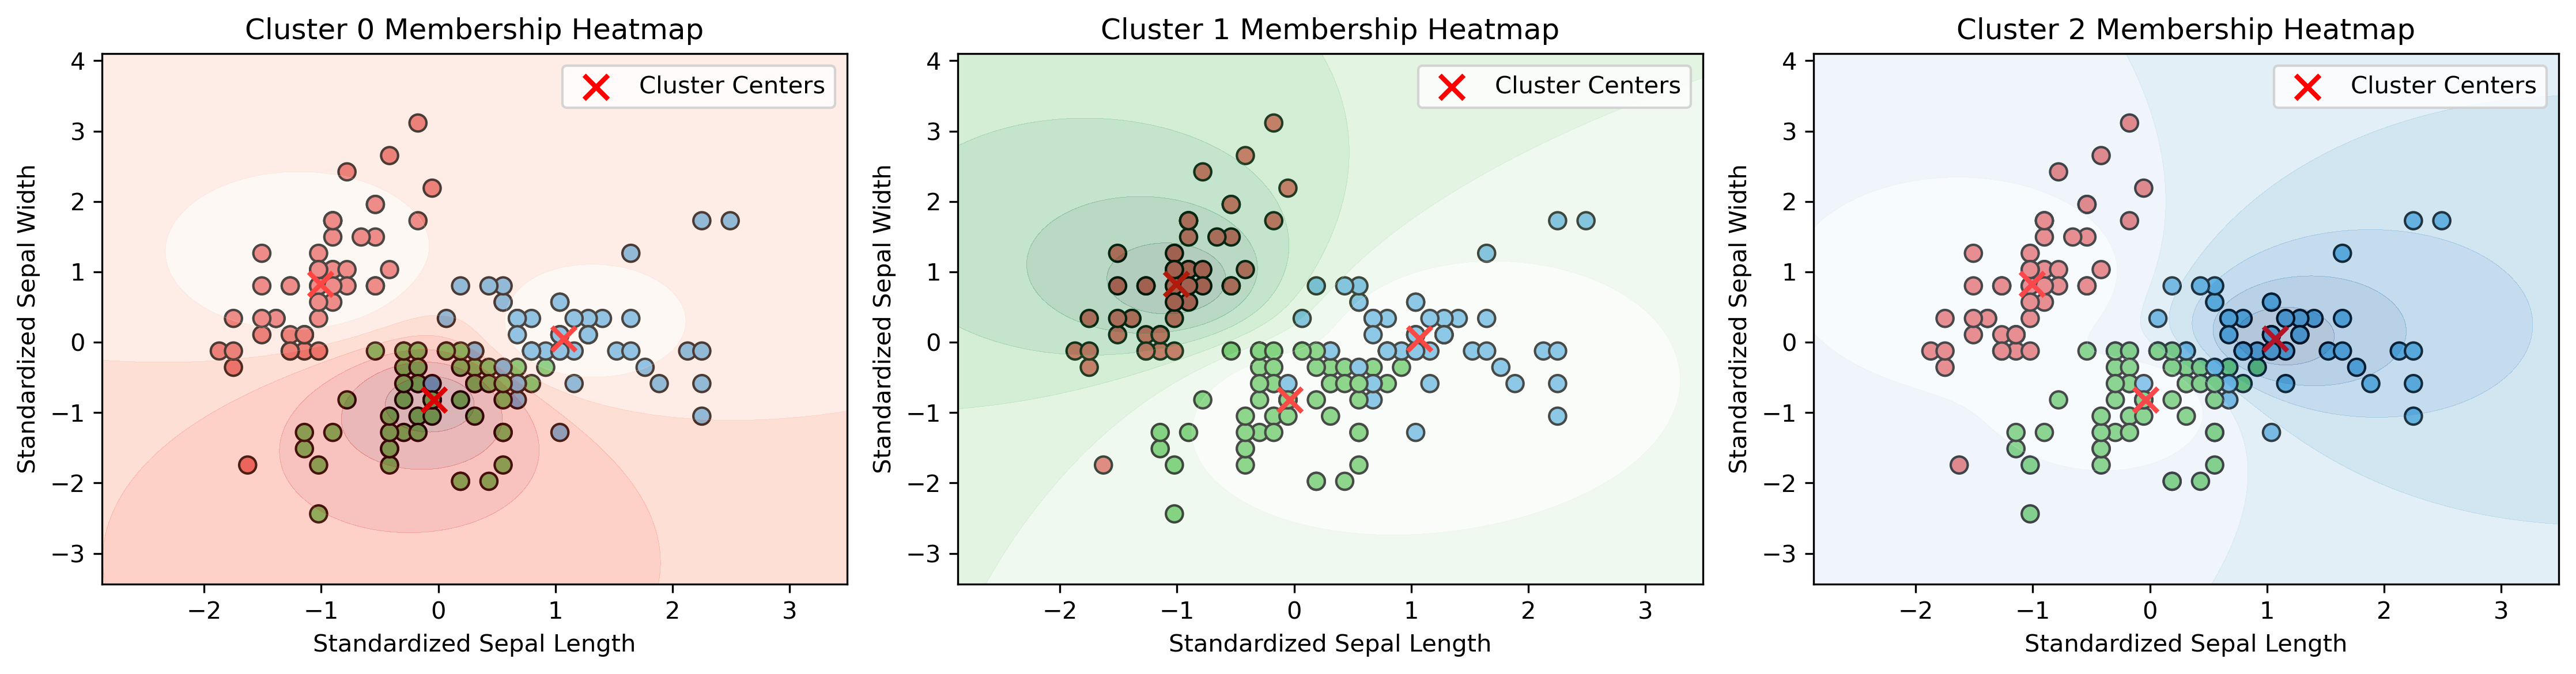

聚类准确率：0.8400


In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns

# 载入 Iris 数据
def load_data(file_path):
    data = []
    labels = []
    label_mapping = {}
    label_index = 0
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                parts = line.split(',')
                features = [float(x) for x in parts[:-1]]
                label = parts[-1]
                if label not in label_mapping:
                    label_mapping[label] = label_index
                    label_index += 1
                data.append(features)
                labels.append(label_mapping[label])
    return np.array(data), np.array(labels)

# Fuzzy C-Means 聚类算法
def fuzzy_c_means(X, c, m=2, max_iter=100, tol=1e-4):
    n_samples, n_features = X.shape
    centroids = X[np.random.choice(n_samples, c, replace=False)]
    for _ in range(max_iter):
        dist = np.zeros((n_samples, c))
        for i in range(c):
            dist[:, i] = np.linalg.norm(X - centroids[i], axis=1)
        U = np.zeros((n_samples, c))
        for j in range(n_samples):
            if np.any(dist[j] == 0):
                zero_idx = np.argwhere(dist[j] == 0).flatten()
                U[j][zero_idx] = 1
            else:
                for i in range(c):
                    U[j, i] = 1.0 / np.sum((dist[j, i] / dist[j]) ** (2 / (m - 1)))
        new_centroids = np.zeros((c, n_features))
        for i in range(c):
            numerator = np.sum((U[:, i] ** m).reshape(-1, 1) * X, axis=0)
            denominator = np.sum(U[:, i] ** m)
            new_centroids[i] = numerator / denominator
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    labels = np.argmax(U, axis=1)
    loss = np.sum((U ** m) * (dist ** 2))
    return centroids, labels, loss, U

# 多次初始化选择最佳聚类
def best_fcm_with_multiple_inits(X, c, m=2, n_init=20):
    best_loss = np.inf
    best_centroids = None
    best_labels = None
    best_U = None
    for _ in range(n_init):
        centroids, labels, loss, U = fuzzy_c_means(X, c, m)
        if loss < best_loss:
            best_loss = loss
            best_centroids = centroids
            best_labels = labels
            best_U = U
    return best_centroids, best_labels, best_loss, best_U

# 标签映射
def map_labels(true_labels, cluster_labels):
    D = max(true_labels.max(), cluster_labels.max()) + 1
    cost_matrix = np.zeros((D, D))
    for i in range(len(true_labels)):
        cost_matrix[true_labels[i], cluster_labels[i]] += 1
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)
    mapping = dict(zip(col_ind, row_ind))
    return np.array([mapping[label] for label in cluster_labels])

# 主程序
data_path = 'dataset/iris/iris.data'
X_raw, y = load_data(data_path)

# 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
X_2d = X_scaled[:, :2]  # 仅用于画图

# 聚类
c = 3
m = 2
n_init = 20
centroids, cluster_labels, loss, U_train = best_fcm_with_multiple_inits(X_scaled, c, m, n_init=n_init)
mapped_labels = map_labels(y, cluster_labels)

# 可视化颜色映射
color_map = {0: (230/255, 100/255, 100/255), 1: (100/255, 200/255, 100/255), 2: (100/255, 180/255, 230/255)}
scatter_colors = [color_map[label] for label in mapped_labels]

# 画图：聚类结果 + 混淆矩阵
plt.figure(figsize=(10, 4), dpi=300)

plt.subplot(1, 2, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=scatter_colors, edgecolor='k', s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, linewidths=2, color='r', label='Cluster Centers')
plt.title('Fuzzy C-Means Clustering (First 2 Standardized Features)')
plt.xlabel('Standardized Sepal Length')
plt.ylabel('Standardized Sepal Width')
plt.legend()

plt.subplot(1, 2, 2)
cm_mapped = confusion_matrix(y, mapped_labels)
sns.heatmap(cm_mapped, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (After Label Mapping)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()

# 画图：三类热力图（基于前两维）
plt.figure(figsize=(15, 4), dpi=300)
cmaps = ['Reds', 'Greens', 'Blues']

for i in range(c):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=scatter_colors, edgecolor='k', s=50)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, linewidths=2, color='r', label='Cluster Centers')

    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    dist_grid = np.zeros((grid.shape[0], c))
    for j in range(c):
        diff = grid - centroids[j, :2]
        dist_grid[:, j] = np.linalg.norm(diff, axis=1)
    U_grid = 1 / (dist_grid ** (2 / (m - 1)))
    U_grid = U_grid / np.sum(U_grid, axis=1, keepdims=True)

    plt.contourf(xx, yy, U_grid[:, i].reshape(xx.shape), alpha=0.3, cmap=cmaps[i])
    plt.title(f'Cluster {i} Membership Heatmap')
    plt.xlabel('Standardized Sepal Length')
    plt.ylabel('Standardized Sepal Width')
    plt.legend()

plt.tight_layout()
plt.show()

# 输出准确率
acc = accuracy_score(y, mapped_labels)
print(f"聚类准确率：{acc:.4f}")

### Wine数据集

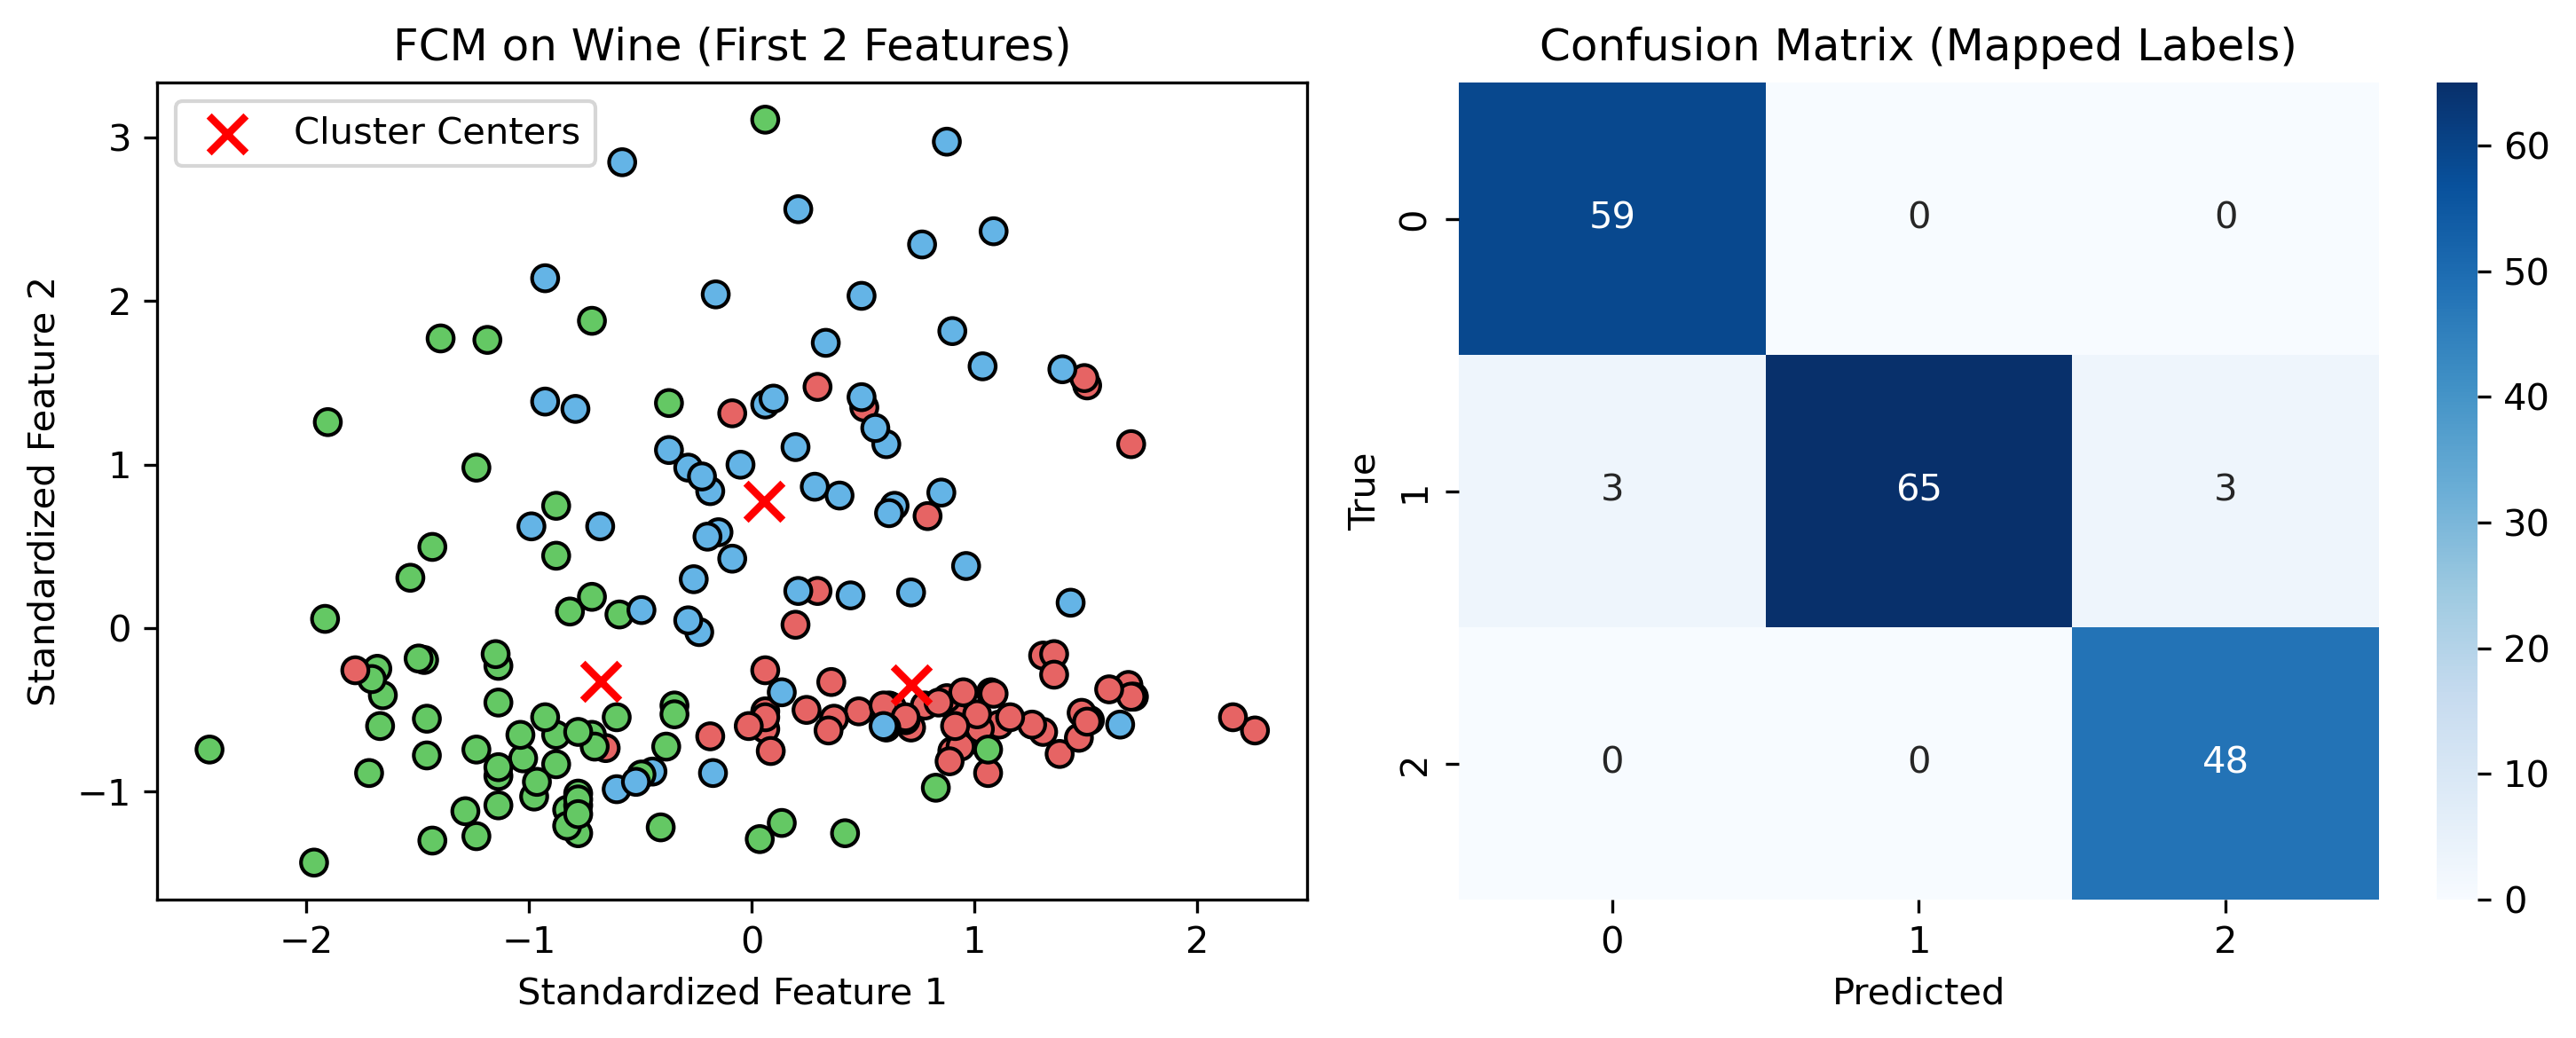

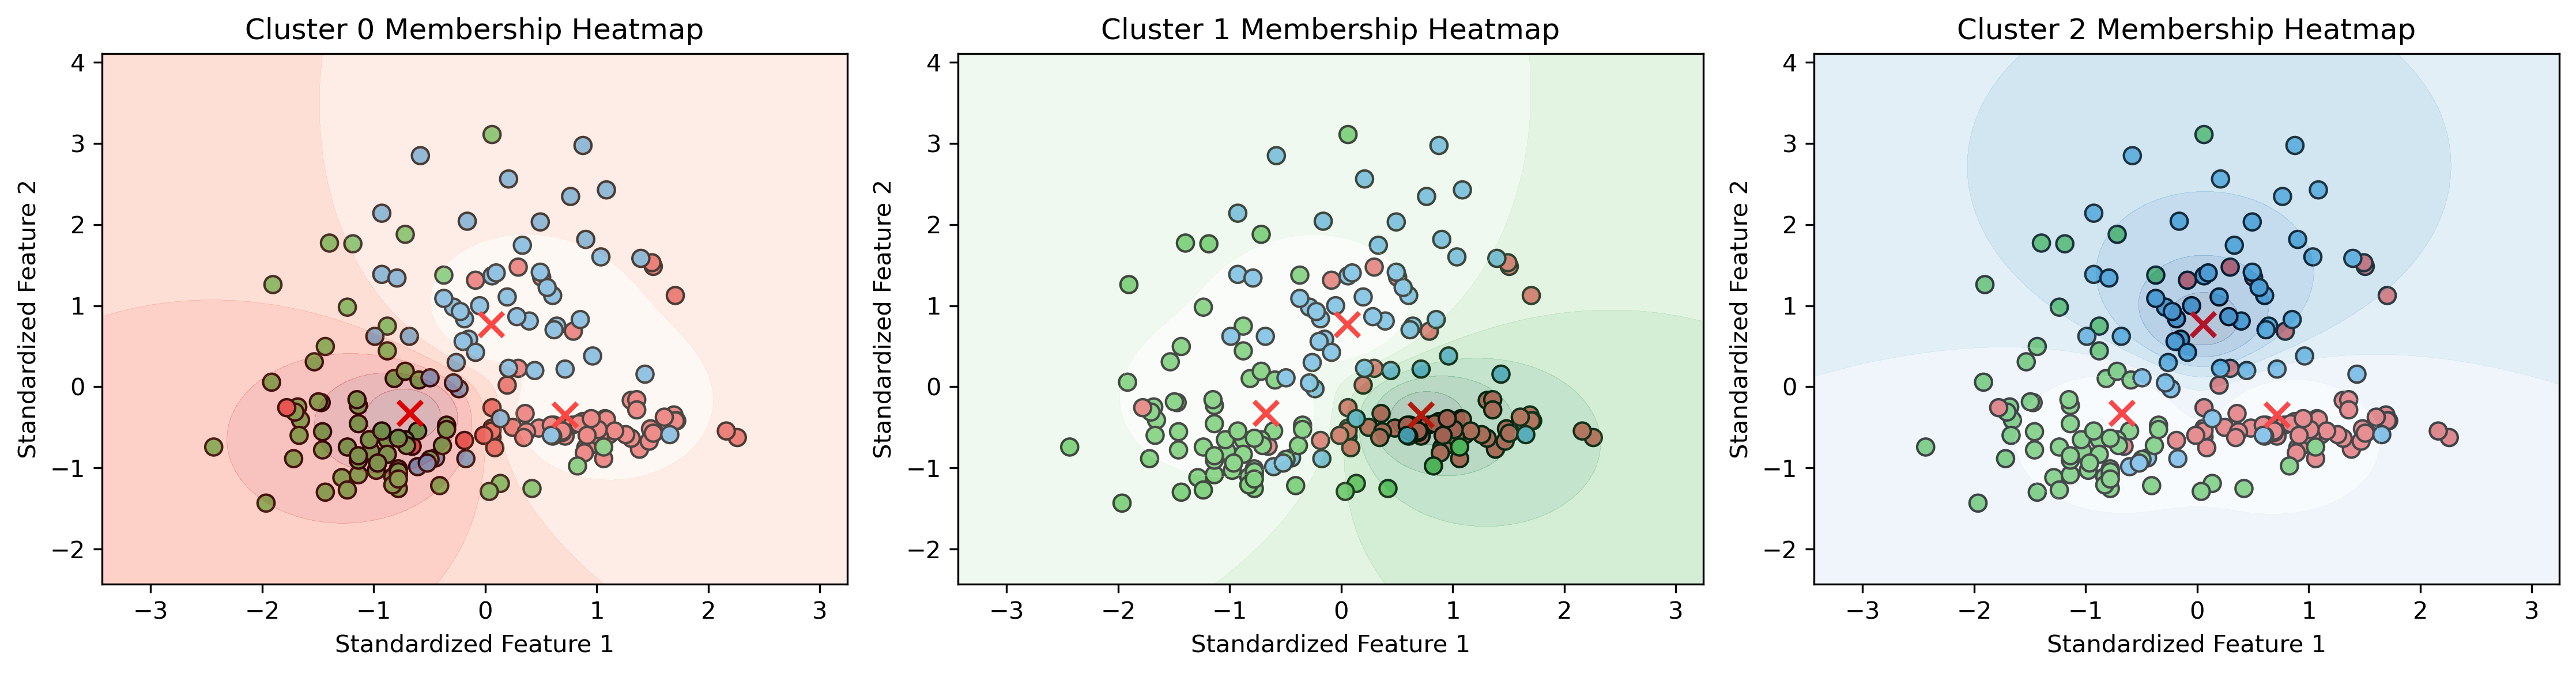

聚类准确率：0.9663


In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns

# 载入 Wine 数据
def load_wine_data(file_path):
    data = []
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                parts = line.split(',')
                labels.append(int(parts[0]) - 1)  # Wine 数据第一列是类别，从1开始
                features = [float(x) for x in parts[1:]]
                data.append(features)
    return np.array(data), np.array(labels)

# Fuzzy C-Means 聚类算法（同原始代码）
def fuzzy_c_means(X, c, m=2, max_iter=100, tol=1e-4):
    n_samples, n_features = X.shape
    centroids = X[np.random.choice(n_samples, c, replace=False)]
    for _ in range(max_iter):
        dist = np.zeros((n_samples, c))
        for i in range(c):
            dist[:, i] = np.linalg.norm(X - centroids[i], axis=1)
        U = np.zeros((n_samples, c))
        for j in range(n_samples):
            if np.any(dist[j] == 0):
                zero_idx = np.argwhere(dist[j] == 0).flatten()
                U[j][zero_idx] = 1
            else:
                for i in range(c):
                    U[j, i] = 1.0 / np.sum((dist[j, i] / dist[j]) ** (2 / (m - 1)))
        new_centroids = np.zeros((c, n_features))
        for i in range(c):
            numerator = np.sum((U[:, i] ** m).reshape(-1, 1) * X, axis=0)
            denominator = np.sum(U[:, i] ** m)
            new_centroids[i] = numerator / denominator
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    labels = np.argmax(U, axis=1)
    loss = np.sum((U ** m) * (dist ** 2))
    return centroids, labels, loss, U

def best_fcm_with_multiple_inits(X, c, m=2, n_init=20):
    best_loss = np.inf
    best_centroids, best_labels, best_U = None, None, None
    for _ in range(n_init):
        centroids, labels, loss, U = fuzzy_c_means(X, c, m)
        if loss < best_loss:
            best_loss = loss
            best_centroids = centroids
            best_labels = labels
            best_U = U
    return best_centroids, best_labels, best_loss, best_U

def map_labels(true_labels, cluster_labels):
    D = max(true_labels.max(), cluster_labels.max()) + 1
    cost_matrix = np.zeros((D, D))
    for i in range(len(true_labels)):
        cost_matrix[true_labels[i], cluster_labels[i]] += 1
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)
    mapping = dict(zip(col_ind, row_ind))
    return np.array([mapping[label] for label in cluster_labels])

# 主程序
data_path = 'dataset/wine/wine.data'
X_raw, y = load_wine_data(data_path)

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
X_2d = X_scaled[:, :2]  # 用前两维可视化

# 聚类
c = 3
m = 2
centroids, cluster_labels, loss, U_train = best_fcm_with_multiple_inits(X_scaled, c, m)
mapped_labels = map_labels(y, cluster_labels)

# 可视化颜色映射
color_map = {0: (230/255, 100/255, 100/255), 1: (100/255, 200/255, 100/255), 2: (100/255, 180/255, 230/255)}
scatter_colors = [color_map[label] for label in mapped_labels]

# 聚类结果图 + 混淆矩阵
plt.figure(figsize=(10, 4), dpi=300)

plt.subplot(1, 2, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=scatter_colors, edgecolor='k', s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, linewidths=2, color='r', label='Cluster Centers')
plt.title('FCM on Wine (First 2 Features)')
plt.xlabel('Standardized Feature 1')
plt.ylabel('Standardized Feature 2')
plt.legend()

plt.subplot(1, 2, 2)
cm_mapped = confusion_matrix(y, mapped_labels)
sns.heatmap(cm_mapped, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Mapped Labels)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

# 各类别热力图（基于前两维）
plt.figure(figsize=(15, 4), dpi=300)
cmaps = ['Reds', 'Greens', 'Blues']

for i in range(c):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=scatter_colors, edgecolor='k', s=50)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, linewidths=2, color='r')
    
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    dist_grid = np.zeros((grid.shape[0], c))
    for j in range(c):
        diff = grid - centroids[j, :2]
        dist_grid[:, j] = np.linalg.norm(diff, axis=1)
    U_grid = 1 / (dist_grid ** (2 / (m - 1)))
    U_grid = U_grid / np.sum(U_grid, axis=1, keepdims=True)

    plt.contourf(xx, yy, U_grid[:, i].reshape(xx.shape), alpha=0.3, cmap=cmaps[i])
    plt.title(f'Cluster {i} Membership Heatmap')
    plt.xlabel('Standardized Feature 1')
    plt.ylabel('Standardized Feature 2')

plt.tight_layout()
plt.show()

# 输出准确率
acc = accuracy_score(y, mapped_labels)
print(f"聚类准确率：{acc:.4f}")

### seeds数据集

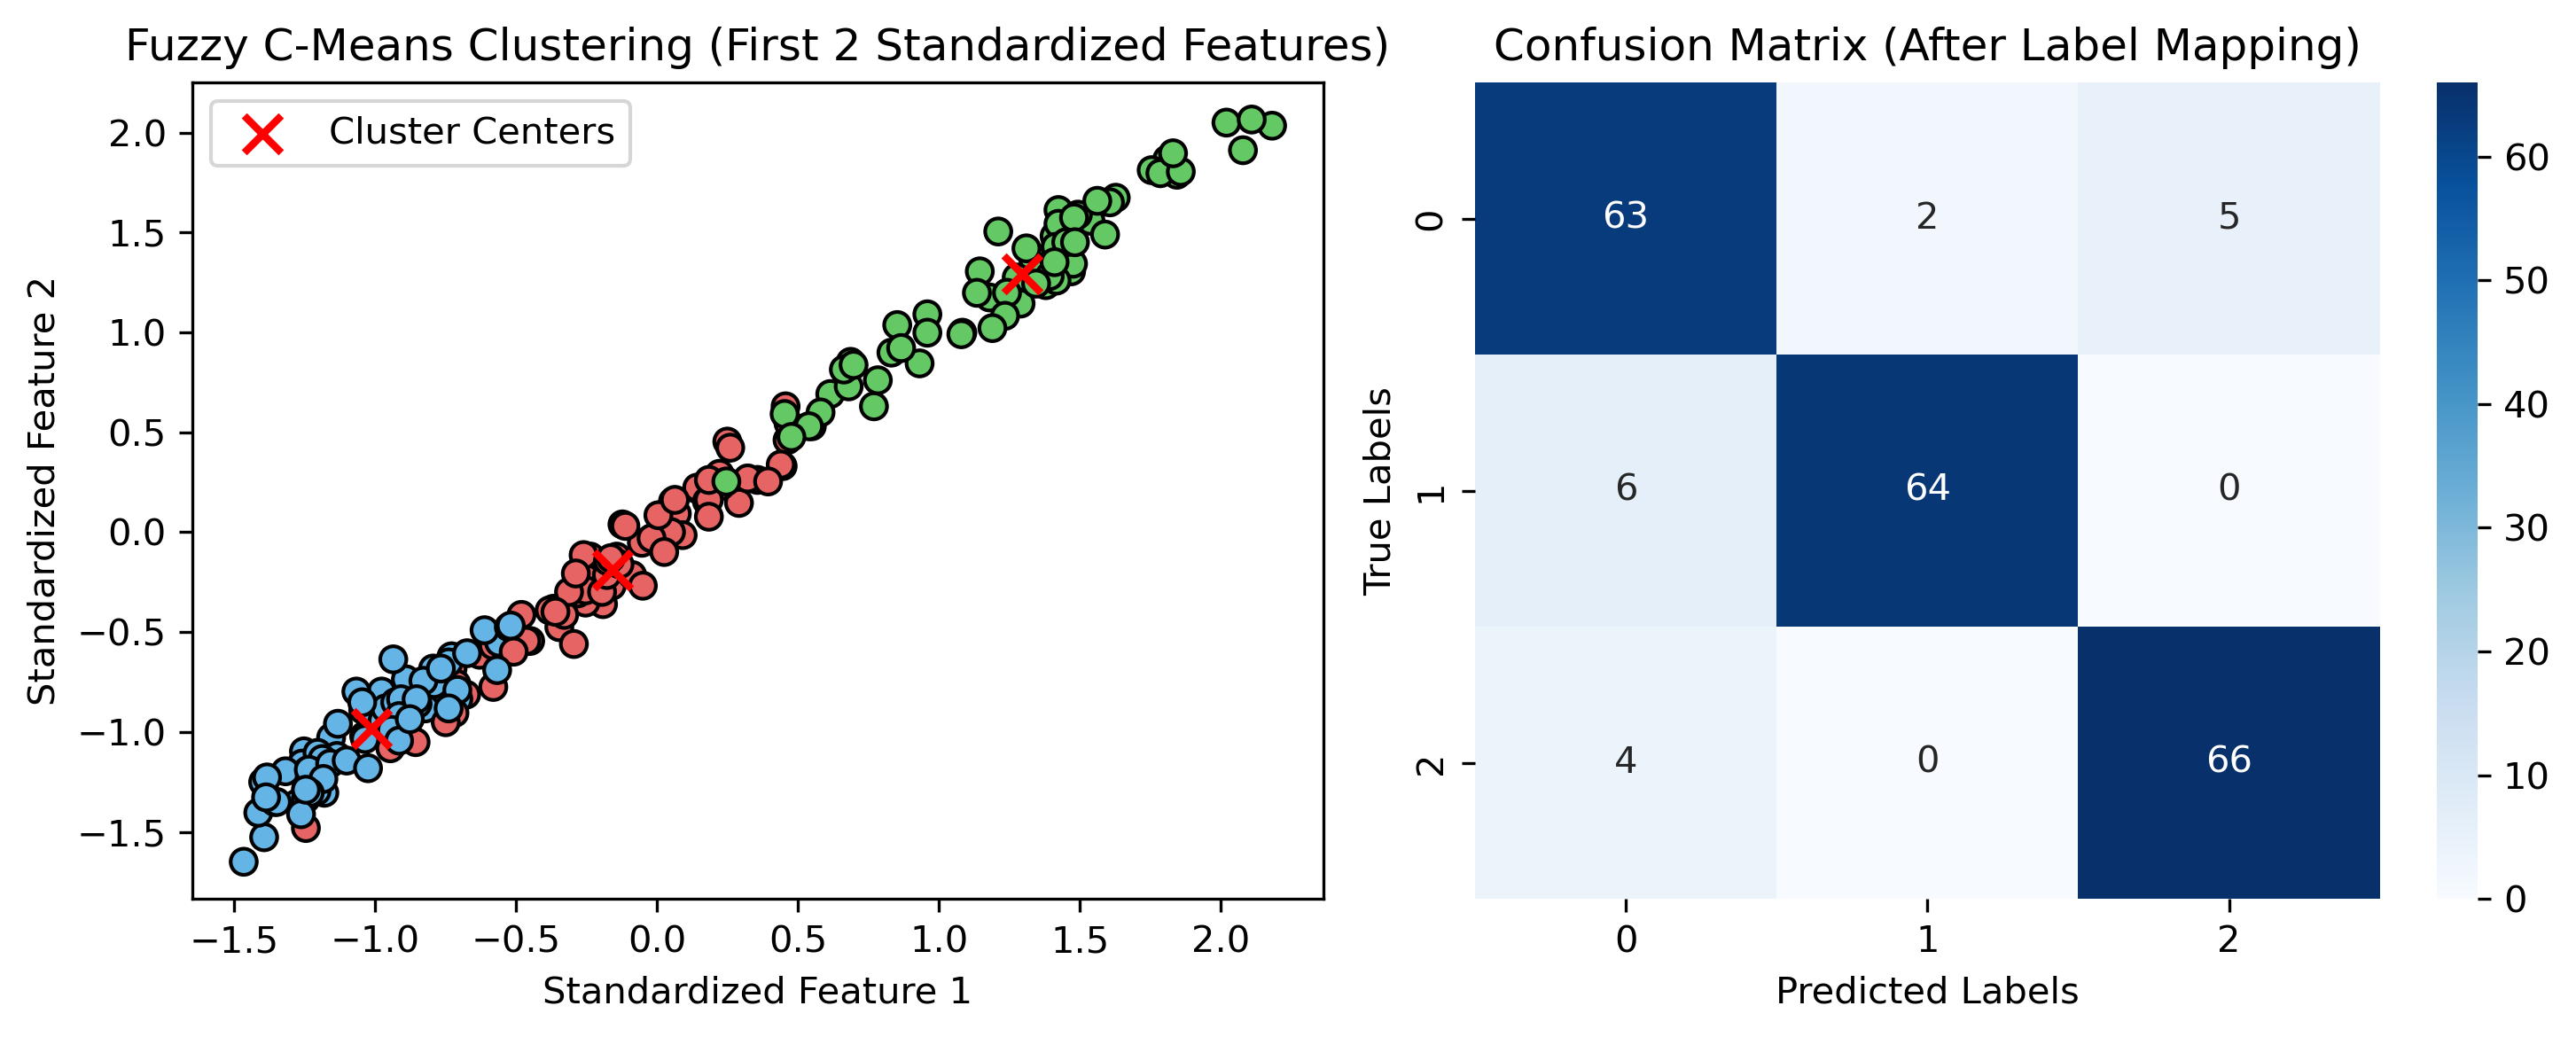

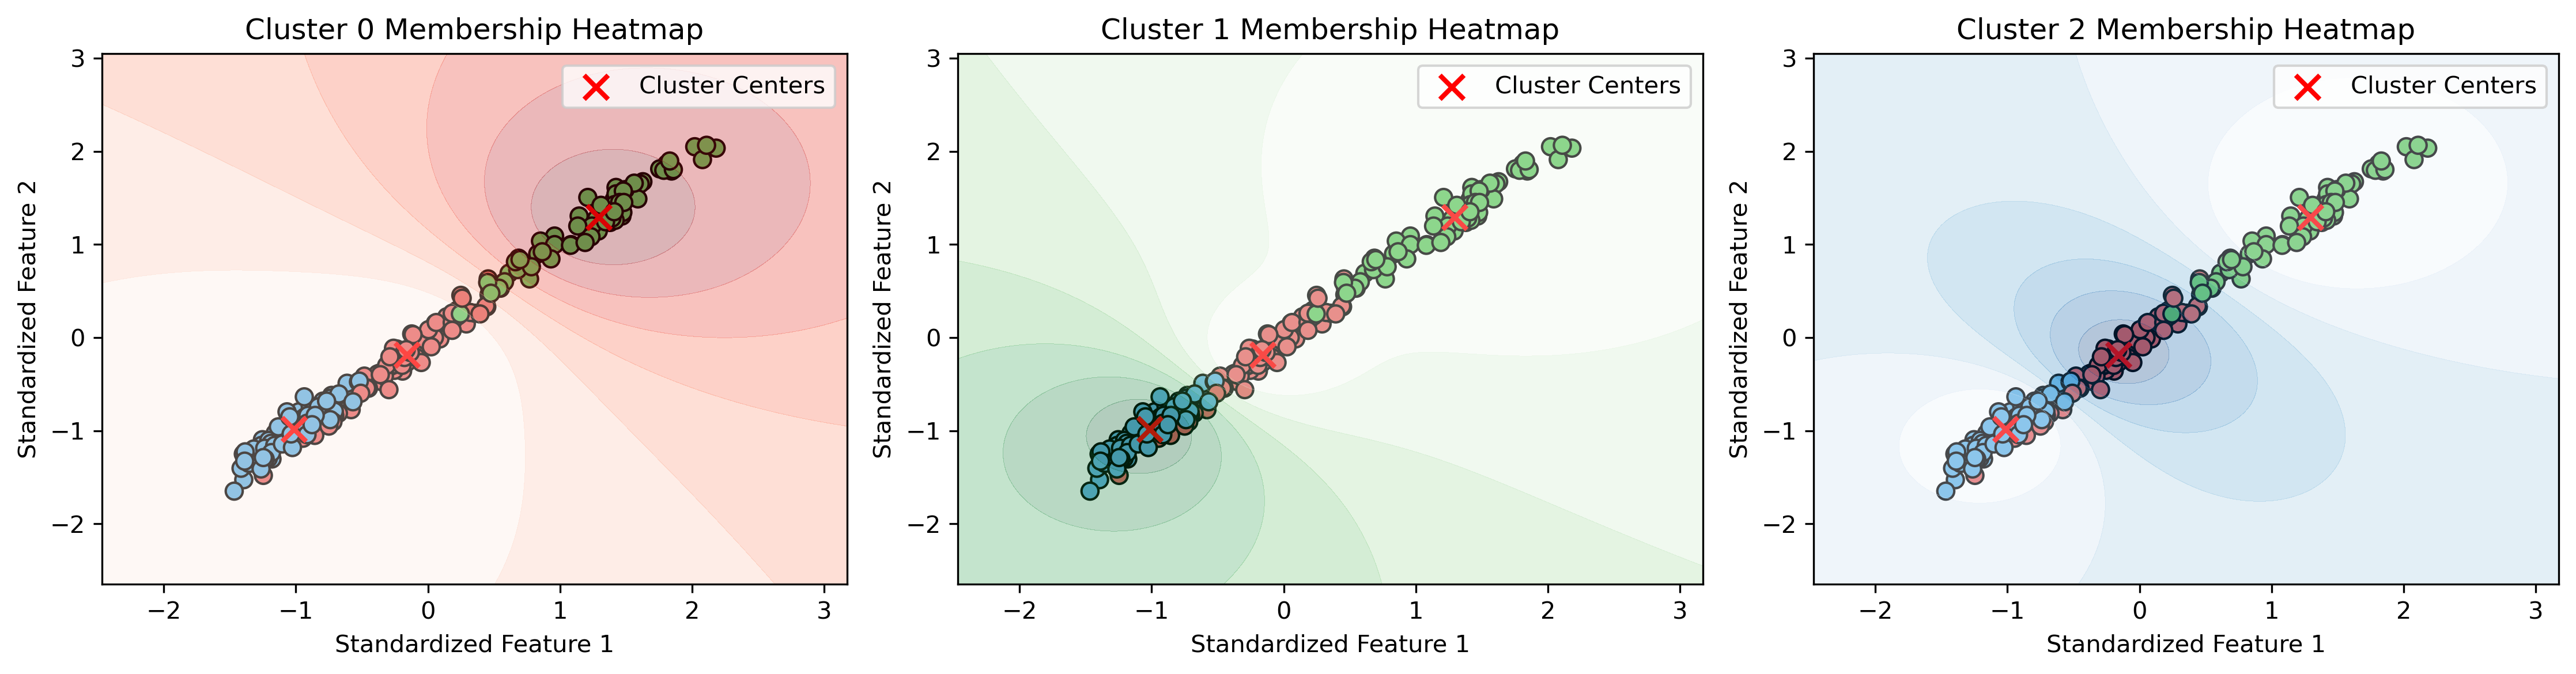

聚类准确率：0.9190


In [15]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns

# 载入 Seeds 数据（修改此函数以适配 seeds_dataset.txt）
def load_data(file_path):
    data = []
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                parts = line.split()  # 使用 split() 自动处理制表符和空格
                features = [float(x) for x in parts[:-1]]
                label = int(parts[-1]) - 1  # 将 1,2,3 转换为 0,1,2
                data.append(features)
                labels.append(label)
    return np.array(data), np.array(labels)

# Fuzzy C-Means 聚类算法（保持不变）
def fuzzy_c_means(X, c, m=2, max_iter=100, tol=1e-4):
    n_samples, n_features = X.shape
    centroids = X[np.random.choice(n_samples, c, replace=False)]
    for _ in range(max_iter):
        dist = np.zeros((n_samples, c))
        for i in range(c):
            dist[:, i] = np.linalg.norm(X - centroids[i], axis=1)
        U = np.zeros((n_samples, c))
        for j in range(n_samples):
            if np.any(dist[j] == 0):
                zero_idx = np.argwhere(dist[j] == 0).flatten()
                U[j][zero_idx] = 1
            else:
                for i in range(c):
                    U[j, i] = 1.0 / np.sum((dist[j, i] / dist[j]) ** (2 / (m - 1)))
        new_centroids = np.zeros((c, n_features))
        for i in range(c):
            numerator = np.sum((U[:, i] ** m).reshape(-1, 1) * X, axis=0)
            denominator = np.sum(U[:, i] ** m)
            new_centroids[i] = numerator / denominator
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    labels = np.argmax(U, axis=1)
    loss = np.sum((U ** m) * (dist ** 2))
    return centroids, labels, loss, U

# 多次初始化
def best_fcm_with_multiple_inits(X, c, m=2, n_init=20):
    best_loss = np.inf
    best_centroids = None
    best_labels = None
    best_U = None
    for _ in range(n_init):
        centroids, labels, loss, U = fuzzy_c_means(X, c, m)
        if loss < best_loss:
            best_loss = loss
            best_centroids = centroids
            best_labels = labels
            best_U = U
    return best_centroids, best_labels, best_loss, best_U

# 标签映射
def map_labels(true_labels, cluster_labels):
    D = max(true_labels.max(), cluster_labels.max()) + 1
    cost_matrix = np.zeros((D, D))
    for i in range(len(true_labels)):
        cost_matrix[true_labels[i], cluster_labels[i]] += 1
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)
    mapping = dict(zip(col_ind, row_ind))
    return np.array([mapping[label] for label in cluster_labels])

# 主程序
data_path = 'dataset/seeds/seeds_dataset.txt'  # 修改数据路径
X_raw, y = load_data(data_path)

# 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
X_2d = X_scaled[:, :2]  # 仅用于画图

# 聚类
c = 3
m = 2
n_init = 20
centroids, cluster_labels, loss, U_train = best_fcm_with_multiple_inits(X_scaled, c, m, n_init=n_init)
mapped_labels = map_labels(y, cluster_labels)

# 可视化颜色映射
color_map = {0: (230/255, 100/255, 100/255), 1: (100/255, 200/255, 100/255), 2: (100/255, 180/255, 230/255)}
scatter_colors = [color_map[label] for label in mapped_labels]

# 图 1：聚类结果 + 混淆矩阵
plt.figure(figsize=(10, 4), dpi=300)

plt.subplot(1, 2, 1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=scatter_colors, edgecolor='k', s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, linewidths=2, color='r', label='Cluster Centers')
plt.title('Fuzzy C-Means Clustering (First 2 Standardized Features)')
plt.xlabel('Standardized Feature 1')
plt.ylabel('Standardized Feature 2')
plt.legend()

plt.subplot(1, 2, 2)
cm_mapped = confusion_matrix(y, mapped_labels)
sns.heatmap(cm_mapped, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (After Label Mapping)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()

# 图 2：三类模糊隶属度热力图（基于前两维）
plt.figure(figsize=(15, 4), dpi=300)
cmaps = ['Reds', 'Greens', 'Blues']

for i in range(c):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=scatter_colors, edgecolor='k', s=50)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, linewidths=2, color='r', label='Cluster Centers')

    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    dist_grid = np.zeros((grid.shape[0], c))
    for j in range(c):
        diff = grid - centroids[j, :2]
        dist_grid[:, j] = np.linalg.norm(diff, axis=1)
    U_grid = 1 / (dist_grid ** (2 / (m - 1)))
    U_grid = U_grid / np.sum(U_grid, axis=1, keepdims=True)

    plt.contourf(xx, yy, U_grid[:, i].reshape(xx.shape), alpha=0.3, cmap=cmaps[i])
    plt.title(f'Cluster {i} Membership Heatmap')
    plt.xlabel('Standardized Feature 1')
    plt.ylabel('Standardized Feature 2')
    plt.legend()

plt.tight_layout()
plt.show()

# 输出准确率
acc = accuracy_score(y, mapped_labels)
print(f"聚类准确率：{acc:.4f}")